# Setup

In [74]:
import torch as t
from torch.nn import functional as F
from nnsight import LanguageModel

import sys
sys.path.append('../')
from acdc import patching_on_y
from loading_utils import DictionaryCfg, load_examples
from circuit import Circuit

In [12]:
model = LanguageModel('EleutherAI/pythia-70m-deduped', dispatch=True)

dict_cfg = DictionaryCfg(
    dictionary_dir='/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/',
    dictionary_size=32768
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [19]:
prompt = "The man"
pad_length = 10
unpadded = model.tokenizer(prompt, return_tensors="pt", padding=False).input_ids
padded = F.pad(unpadded, (0, pad_length), value=model.tokenizer.pad_token_id)

print(f'padded tensor: {padded}')
print(f'unpadded tensor: {unpadded}')

padded tensor: tensor([[510, 637,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])
unpadded tensor: tensor([[510, 637]])


In [29]:
# Toy dataset for the "Plural" task
tok = lambda x: t.tensor(model.tokenizer.encode(x))
toy_dataset_unpad = [dict(
    clean_prefix=tok("The man"),
    clean_answer=tok(" is"),
    patch_prefix=tok("The men"),
    patch_answer=tok(" are"),
    prefix_length_wo_pad=len(unpadded[0]),
)]

pad_length = 10
pad = lambda x: F.pad(tok(x), (0, pad_length), value=model.tokenizer.pad_token_id)
toy_dataset_pad = [dict(
    clean_prefix=pad("The man"),
    clean_answer=tok(" is"),
    patch_prefix=pad("The men"),
    patch_answer=tok(" are"),
    prefix_length_wo_pad=len(unpadded[0]),
)]

In [40]:
def load_submodule(model, submodule_str):
    if "." not in submodule_str:
        return getattr(model, submodule_str)
    
    submodules = submodule_str.split(".")
    curr_module = None
    for module in submodules:
        if module == "model":
            continue
        if not curr_module:
            curr_module = getattr(model, module)
            continue
        curr_module = getattr(curr_module, module)
    return curr_module

submod_name = 'model.gpt_neox.layers.4.mlp.dense_4h_to_h'
submodule = load_submodule(model, submod_name)

# Right padding affects MLP activations

In [41]:
with model.invoke(padded, fwd_args={'inference' : True}) as invoker:
    mlp_act_pad = submodule.output.save()

with model.invoke(unpadded, fwd_args={'inference' : True}) as invoker:
    mlp_act_unpad = submodule.output.save()

In [42]:
# Difference in mlp activations for token position
print(f'Difference in mlp activations for token "{model.tokenizer.decode(padded[0, 1])}" at position 1.')

mlp_abs_diff = (mlp_act_pad.value[0, 1, :] - mlp_act_unpad.value[0, 1, :]).abs().sum()
rel_diff = mlp_abs_diff / mlp_act_unpad.value[0, 1, :].sum()
print(f'shapes: {mlp_act_pad.value.shape}, {mlp_act_unpad.value.shape}')
print(f'abs diff: {mlp_abs_diff}')
print(f'rel diff: {rel_diff}')

Difference in mlp activations for token " man" at position 1.
shapes: torch.Size([1, 12, 512]), torch.Size([1, 2, 512])
abs diff: 0.002638685517013073
rel diff: -0.0007830197573639452


# Right padding affects feature effects on y

In [61]:
submod_name = 'model.gpt_neox.layers.3.mlp.dense_4h_to_h'

effects_on_y_pad, total_effect_on_y_pad = patching_on_y(
    toy_dataset_pad,
    model,
    upstream_submodule_names=[submod_name],
    dict_cfg=dict_cfg,
    method='separate'
)
effects_on_y_unpad, total_effect_on_y_unpad = patching_on_y(
    toy_dataset_unpad,
    model,
    upstream_submodule_names=[submod_name],
    dict_cfg=dict_cfg,
    method='separate'
)

In [66]:
eff_y_pad = effects_on_y_pad[submod_name][:2]
eff_y_unpad = effects_on_y_unpad[submod_name][:2]
eff_y_pad.shape

torch.Size([2, 32768])

In [69]:
(eff_y_pad - eff_y_unpad).abs().max()

tensor(0.0002, grad_fn=<MaxBackward1>)

In [68]:
eff_y_unpad.abs().max(), eff_y_unpad[eff_y_unpad>0].abs().min()

(tensor(0.1171, grad_fn=<MaxBackward1>),
 tensor(7.2724e-05, grad_fn=<MinBackward1>))

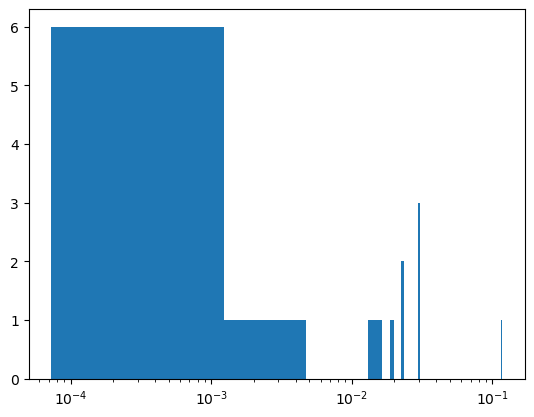

In [73]:
import matplotlib.pyplot as plt
plt.hist(eff_y_unpad[eff_y_unpad>0].abs().detach().numpy(), bins=100)
plt.xscale('log')

# Right padding affects circuits found

In [77]:
model_name = "EleutherAI/pythia-70m-deduped"
submodules_generic = ["model.gpt_neox.layers.{}.mlp.dense_4h_to_h"]
dictionary_dir = "/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped"
dictionary_size = 32768
dataset_dir_share = "/share/projects/dictionary_circuits/data/phenomena/simple.json"
num_examples = 100
patch_method = "separate"
y_threshold = 0.1
feat_threshold = 0.1

eff_outs = []
for pad_length in [None, 10]:
    print(f"\n\nPad length: {pad_length}\n\n")

    model = LanguageModel(model_name, dispatch=True)
    model.local_model.requires_grad_(True)
    dataset = load_examples(dataset_dir_share, num_examples, model, pad_to_length=pad_length)

    circuit = Circuit(model, submodules_generic, dictionary_dir, dictionary_size, dataset)
    circuit.y_threshold = y_threshold
    circuit.feat_threshold = feat_threshold
    eff_outs.append(circuit.locate_circuit(patch_method=patch_method))
    print(circuit.to_dict())

# %%
print(f'total effect difference for padding: {eff_outs[0].total_effect.abs().sum() - eff_outs[1].total_effect.abs().sum()}')
for i in range (6):
    print(f"\nSubmodule: {i}")
    submod_name = f'model.gpt_neox.layers.{i}.mlp.dense_4h_to_h'
    effects_pos1_nopad = eff_outs[0].effects[submod_name].abs()[1, :]
    effects_pos1_pad = eff_outs[1].effects[submod_name].abs()[1, :]
    print(f'sum of effect diff: {effects_pos1_pad.sum() - effects_pos1_nopad.sum()}')
    print(f'max effect diff: {(effects_pos1_nopad - effects_pos1_pad).max()}')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.




Pad length: None




You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
downstream_submodules:   0%|          | 0/1 [00:00<?, ?it/s]

5_22167_mlp


downstream_submodules:   0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 